### Series temporales 2

En este notebook voy a usar datos oficiales que provee el tesoro de USA. Voy a levantar los datos del IPC desde el 2000 (hay un monton más!! también hay datos de Yahoo finanzas). Voy a identificar la serie temporal

In [24]:
# Paquetes

import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas_datareader.data import DataReader
import numpy as np
from datetime import date 
import matplotlib as plt
import matplotlib.pyplot as plt
import urllib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf,plot_predict
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [25]:
#Importamos

ipc_usa = DataReader(['CPIAUCSL'],'fred',start=date(2000, 1, 1))#Consumer Price Index for All Urban Consumers: All Items in U.S. City Average
ipc_usa.columns = ['nivel_ipc']

#Desestacionalizamos

seasonal = seasonal_decompose(ipc_usa['nivel_ipc'], model='multiplicative', extrapolate_trend='freq')
deseasonalized = ipc_usa['nivel_ipc'] / seasonal.seasonal
deseasonalized = deseasonalized.to_frame()
deseasonalized.columns = ['nivel_ipc_desc']
ipc_usa = ipc_usa.merge(deseasonalized,how='left',left_index=True,right_index=True)
ipc_usa = ipc_usa[['nivel_ipc_desc']]
ipc_usa.columns = ['nivel_ipc']

# Tomamos la variación interanual

ipc_usa['var_anual_ipc'] = (ipc_usa['nivel_ipc'] / ipc_usa['nivel_ipc'].shift(12) - 1)*100
ipc_usa=ipc_usa[ipc_usa['var_anual_ipc'].notna()]
ipc_usa=ipc_usa[['var_anual_ipc']]

# Diferenciamos la serie

ipc_usa_diff=ipc_usa.diff(1)
ipc_usa_diff.columns = ['var_anual_ipc_diff']
ipc_usa_diff=ipc_usa_diff[ipc_usa_diff['var_anual_ipc_diff'].notna()]

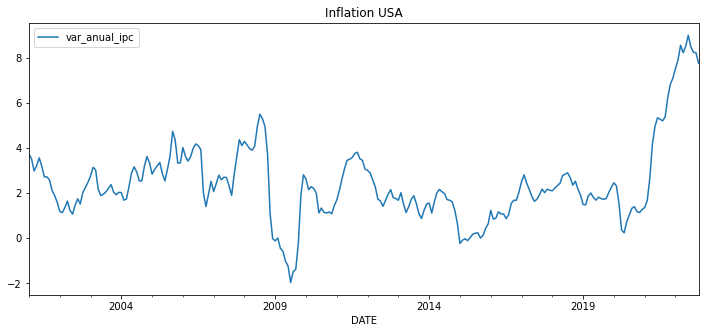

In [26]:
ipc_usa[['var_anual_ipc']].plot(title='Inflation USA',figsize=(12,5))
plt.show()


Verificamos la estacionariedad, la serie a priori se la ve relativamente estacionaria sin diferenciarla, el test nos arroja que por poco si lo es. Sin embargo cuando se avanza con la identificación de la serie nos dan muchos *lags* significativos y nos queda un modelo poco parsimonioso. Por lo que recurrimos a diferenciarla y trabajar con la serie diferenciada.

In [27]:
print('t-statics:',adfuller(ipc_usa['var_anual_ipc'])[0],' p-value:',adfuller(ipc_usa['var_anual_ipc'])[1])

t-statics: -1.812276956569954  p-value: 0.37438378515346327


Serie diferenciada

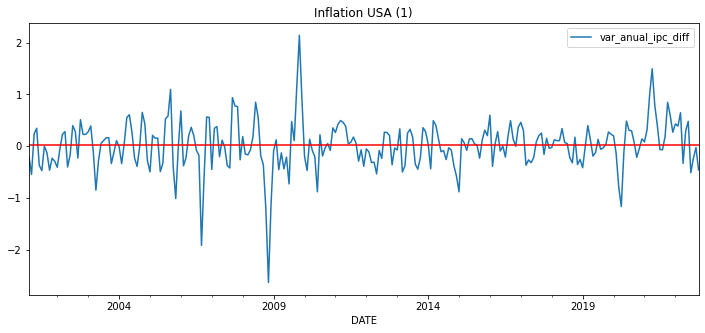

In [28]:
ipc_usa_diff[['var_anual_ipc_diff']].plot(title='Inflation USA (1)',figsize=(12,5))
plt.axhline(ipc_usa_diff.mean()[0],color='red')
plt.show()

In [29]:
print('t-statics:',adfuller(ipc_usa_diff['var_anual_ipc_diff'])[0],' p-value:',adfuller(ipc_usa_diff['var_anual_ipc_diff'])[1])

t-statics: -4.392183803651524  p-value: 0.00030643107099860806


MIramos el *autocorrelation_plot()* vemos que al principio de la serie estan los lags siginificativos.

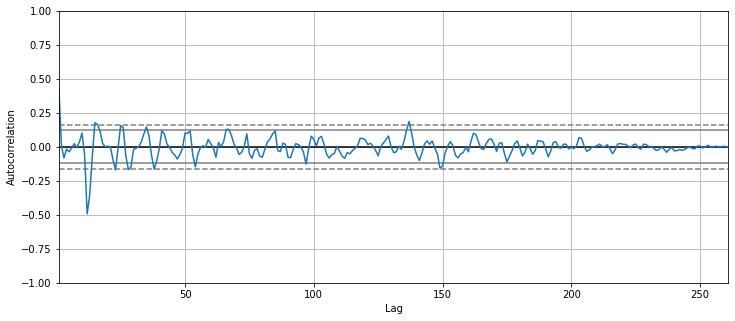

In [30]:
plt.rcParams["figure.figsize"] = (12,5)
autocorrelation_plot(ipc_usa_diff['var_anual_ipc_diff'].tolist())#.set_xlim([1, 15])
plt.show()

La identificación de la serie con el PACF y ACF nos muestran una serie *ARMA (p,q)*, probablemente una ARMA (1,1). Sin embargo se ven muy significativos los *lags* 12 de cada gráfico. Por más que se desestacionalice la serie, muchas veces este procedimiento no es suficiente y hay que incluir los *lags* de los periodos estacionales en el modelo. Probamos el modelo ARMA ([1,12],[1,12]), el mismo nos da que los parámetros MA son levemente significativos mientras que los AR si lo son. Si miramos con amyor detenimiento los gráficos, el segundo *lag* del PACF y el 13 del ACF son algo significativos (más este último). Probando distintas variantes el mejor modelo tomando los criterios de Akaike y Bayesian y teniendo en cuenta la significatividad de los parámetros es el ARMA ([1,12],[1,12,13])

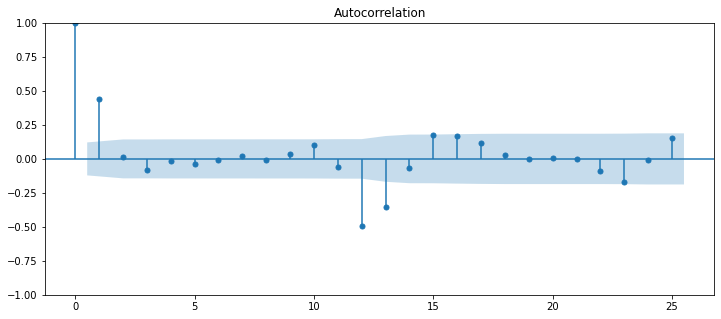

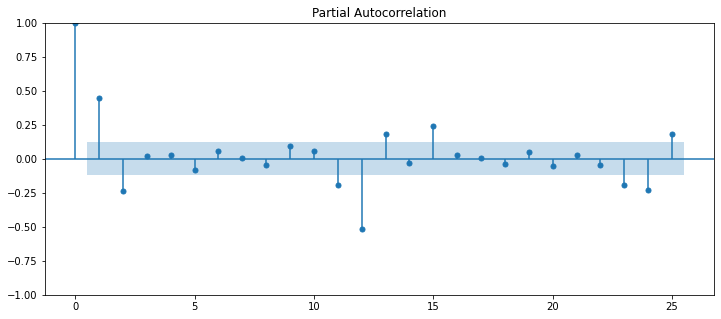

In [31]:
plot_acf(ipc_usa_diff);
plot_pacf(ipc_usa_diff);
plt.rcParams.figsize= (12,5) 

In [32]:
model = ARIMA(ipc_usa_diff,order=([1,12],0,[1,12]))
model = model.fit()
print(model.summary())

                                   SARIMAX Results                                    
Dep. Variable:             var_anual_ipc_diff   No. Observations:                  261
Model:             ARIMA([1, 12], 0, [1, 12])   Log Likelihood                 -55.090
Date:                        Fri, 11 Nov 2022   AIC                            122.180
Time:                                15:02:07   BIC                            143.567
Sample:                            02-01-2001   HQIC                           130.777
                                 - 10-01-2022                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.005      0.637      0.524      -0.007       0.014
ar.L1          0.5029      0.054      9.311      0.000       0.397 

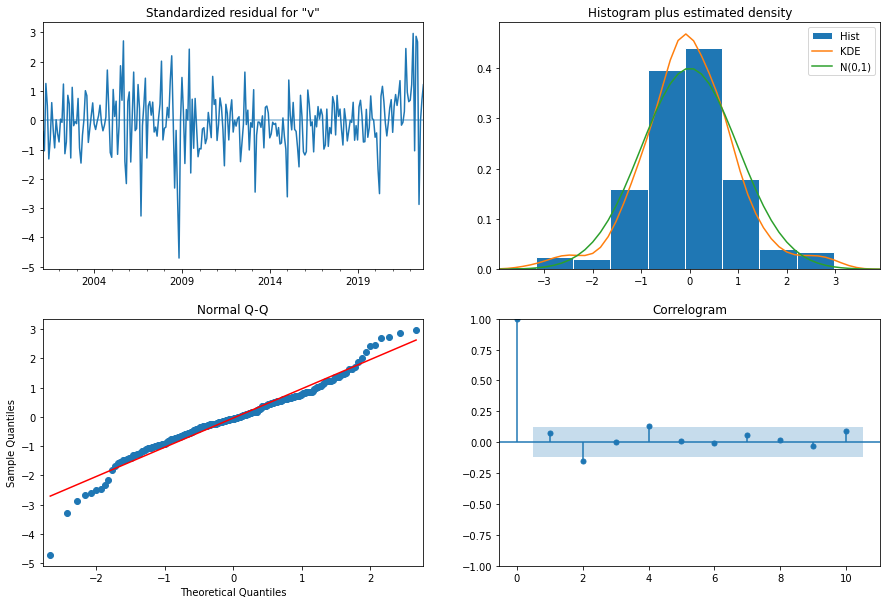

In [33]:
model.plot_diagnostics(figsize = (15, 10))
plt.show()

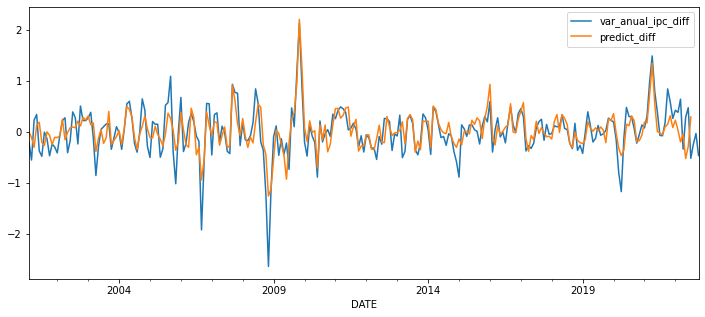

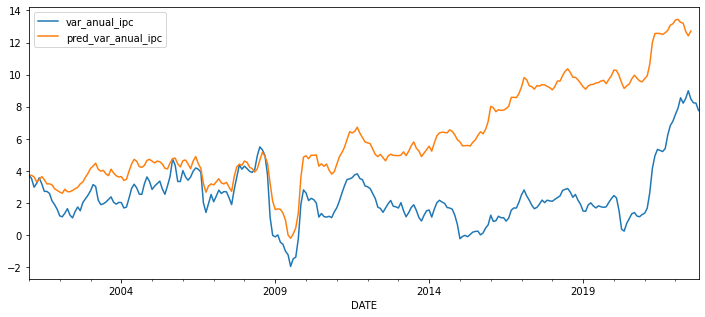

In [34]:
pred_insample = model.get_prediction(start='2001-02-01', end='2022-07-01')
pred_insample = pd.Series(pred_insample.predicted_mean).to_frame()
pred_insample.columns = ['predict_diff']
# print(pred.conf_int(alpha=0.05))  # confidence interval
ipc_usa_diff=ipc_usa_diff.merge(pred_insample,how='left',right_index=True,left_index=True)
ipc_usa_diff.plot(figsize=(12,5))
ipc_usa=ipc_usa.merge(ipc_usa_diff,how='left',left_index=True,right_index=True)
ipc_usa['predict_diff'][0] = ipc_usa['var_anual_ipc'][0]
ipc_usa['pred_var_anual_ipc'] = ipc_usa['predict_diff'].cumsum()
ipc_usa[['var_anual_ipc','pred_var_anual_ipc']].plot(figsize=(12,5))
plt.show()

La evaluación nos modelo nos arroja la pista que las colas del la distribución de residuos son pesadas (mirar QQ-plot), también al observar la serie diferenciada nos puede dar la idea que la volatilidad no es constante, por el 2009 tiene tiene unos picos muy pronunciados y en 2021 también. Ademas cuando miramos la predicción vemos que a partir del 2009 se desacompla de la serie original.

Esto puede motivar la idea de analizar si la volatilidad tiene estructura. Para eso recurrimos a los modelos GARCH. Primero testeamos si el error es una proceso aleatorio, de no serlo se justificaría la modelización de la varianza (o volatilidad).

Bajo la hipótesis nula el error es ruido blanco, con un p-value < a 0.05 se rechaza y afirmamos que el error no es ruido blanco. El test da 0.05, muy en el límite. 

In [41]:
#Link interesante https://medium.com/tej-api-%E9%87%91%E8%9E%8D%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90/data-analysis-10-arima-garch-model-part-1-a011bf45f66c

from statsmodels.stats.diagnostic import acorr_ljungbox
arima_resid = model.resid
white_noise_arima = acorr_ljungbox(arima_resid, lags = [10], return_df=True)
white_noise_arima

,lb_stat,lb_pvalue
10,18.081112,0.053611


Probamos un test arch y vemos que el mismo arroja que existe un efecto ARCH, por lo que vamos a modelizar la varianza.

In [37]:
from statsmodels.stats.diagnostic import het_arch
LM_pvalue = het_arch(arima_resid, ddof = 4)[1]
print('LM-test-Pvalue:', '{:.5f}'.format(LM_pvalue))

LM-test-Pvalue: 0.01876


Miramos los PACF y ACF de los residuos cuadráticos. Son apenas significativos el primer lag de cada uno.

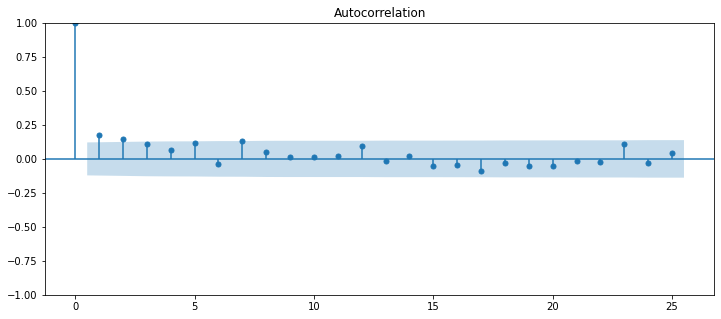

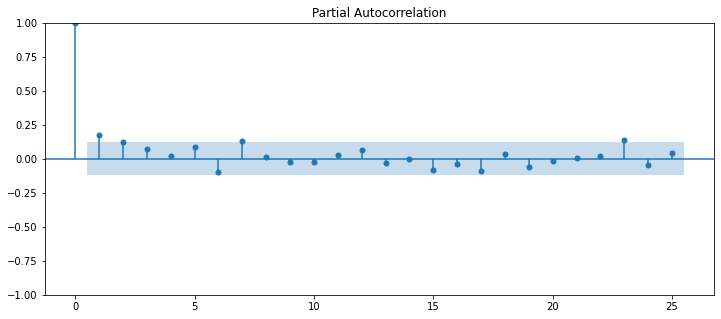

In [40]:
plot_acf(arima_resid**2);
plot_pacf(arima_resid**2);
plt.rcParams.figsize= (12,5) 

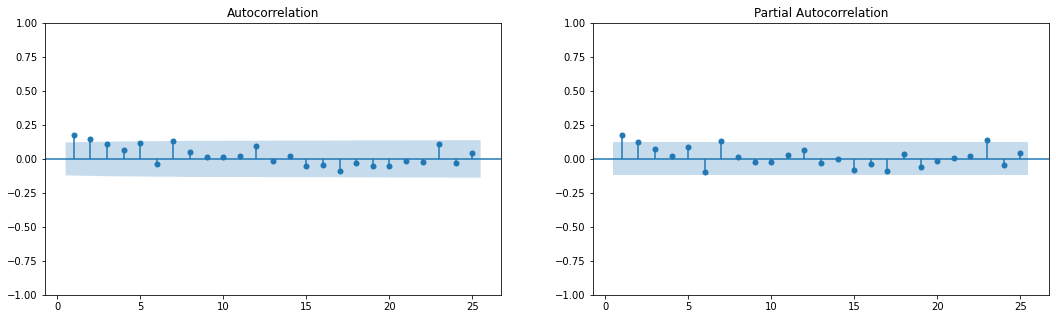

In [38]:
import statsmodels.graphics.tsaplots as sgt
fig, ax = plt.subplots(1, 2, figsize = (18,5))
sgt.plot_acf(arima_resid**2, zero = False, lags = 25, ax=ax[0])
sgt.plot_pacf(arima_resid**2, zero = False, lags = 25, ax=ax[1])
plt.show()

Identificamos el modelo GARCH(1,1), vemos que los coeficientes son significativos.

In [39]:
from arch import arch_model
mdl_garch = arch_model(arima_resid, vol = 'GARCH', p = 1, q = 1)
res_fit = mdl_garch.fit()
res_fit.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4785.88704751277
Iteration:      2,   Func. Count:     15,   Neg. LLF: 846.2395424122534
Iteration:      3,   Func. Count:     24,   Neg. LLF: 65.11800236875814
Iteration:      4,   Func. Count:     31,   Neg. LLF: 46.873502479666364
Iteration:      5,   Func. Count:     38,   Neg. LLF: 37.55853788690908
Iteration:      6,   Func. Count:     43,   Neg. LLF: 37.5585142215543
Iteration:      7,   Func. Count:     47,   Neg. LLF: 37.55851422127646
Optimization terminated successfully    (Exit mode 0)
            Current function value: 37.5585142215543
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -37.5585
Distribution:                  Normal   AIC:                           83.1170
Method:            Maximum Likelihood   BIC:                           97.3751
                                        No. Observations:                  261
Date:                Fri, Nov 11 2022   Df Residuals:                      260
Time:                        15:02:10   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu            -0.0219  1.552e-02     -1.408      0.159 [-5.228e-02,8.562e-03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0111  8.669e-03      1.279      0.201 [-5.900e-03,2.808e-02]
alpha[1]       0.2004      0.109      1.842  6.540e-02   [-1.278e-02,  0.414]
beta[1]        0.6831      0.175      3.914  9.081e-05      [  0.341,  1.025]
=============================================================================

Covariance estimator: robust
"""